In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import skimage.transform
import skimage.measure
from sklearn.neighbors import BallTree
from sklearn.feature_extraction.image import extract_patches_2d
import scipy
from scipy.spatial.distance import euclidean
from scipy.signal import fftconvolve,correlate
import pandas as pd
import pickle
import cv2
from sklearn.preprocessing import OneHotEncoder
from annoy import AnnoyIndex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
ds = 2
lc_path = "downsampled_data"+str(ds)+"/"
naip_path = "downsampled_data_naip"+str(ds)+"/"
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
def fn(i):
    return paths[i].replace('/','-')[:-7]

def disp(pic):
    plt.figure(figsize=(8,8))
    plt.imshow(pic)
    plt.axis('off')
    plt.show()
    plt.close()

In [14]:
lc = np.load(lc_path+fn(0)+'.npz')['a']
lc2 = np.load(lc_path+fn(1)+'.npz')['a']
print(lc.shape,lc2.shape)

naip = np.load(naip_path+fn(0)+'.npz')['a']
naip = np.rollaxis(naip,0,3)
naip2 = np.load(naip_path+fn(1)+'.npz')['a']
naip2 = np.rollaxis(naip2,0,3)
print(naip.shape,naip2.shape)

(3831, 3093) (3815, 3052)
(3831, 3093, 3) (3815, 3052, 3)


In [15]:
%%time
size = 4
patches = extract_patches_2d(lc,(size,size))
print(patches.shape)
labels, indices,counts = np.unique(patches,axis=0,return_index=True,return_counts=True)
print(labels.shape,indices.shape,counts.shape)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


(11828520, 4, 4)
(785282, 4, 4) (785282,) (785282,)
CPU times: user 1min 7s, sys: 220 ms, total: 1min 7s
Wall time: 1min 7s


In [6]:
%%time
naip_patches = extract_patches_2d(naip2,(size,size))
print(naip_patches.shape)
naip_patches = np.reshape(naip_patches,(-1,3*size**2))
ai = AnnoyIndex(3*size**2)
for idx,i in enumerate(naip_patches):
    ai.add_item(idx,i)
ai.build(25)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


(11622788, 4, 4, 3)
CPU times: user 22min 59s, sys: 11 s, total: 23min 10s
Wall time: 23min 10s


In [7]:
ai.save('annoy_indexes/tile1.ann')

True

In [9]:
%%time
ai = AnnoyIndex(3*size**2)
ai.load('annoy_indexes/tile0.ann')

CPU times: user 312 ms, sys: 1.96 s, total: 2.28 s
Wall time: 5min 36s


In [8]:
%%time
size = 4
x,y,bigsize = 1500,1500,256
query = naip2[x:x+bigsize,y:y+bigsize,:]
results = np.zeros((bigsize,bigsize,7),dtype=int)
for i in range(bigsize-size+1):
    print(i)
    for j in range(bigsize-size+1):
        temp = query[i:i+size,j:j+size,:].flatten()
        nns = ai.get_nns_by_vector(temp,50)
        temp_results = np.rollaxis(patches[nns],0,3)
        temp_bin = np.zeros((size,size,7),dtype=int)
        for k in range(size):
            for l in range(size):
                temp_bin[k,l] = np.bincount(temp_results[k,l],minlength=7)
        results[i:i+size,j:j+size] += temp_bin
print(results.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
(256, 256, 7)
CPU times: user 30 s, sys: 88.7 ms, total: 30.1 s
Wall time: 29.9 s


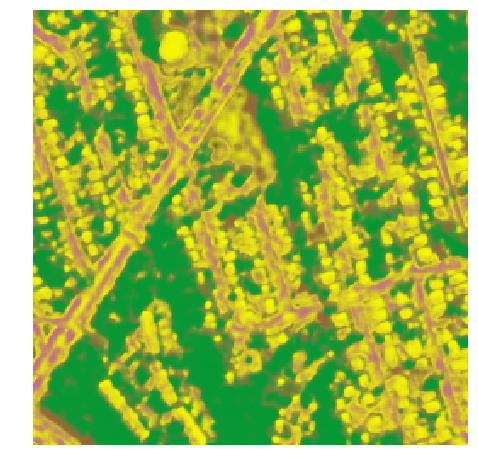

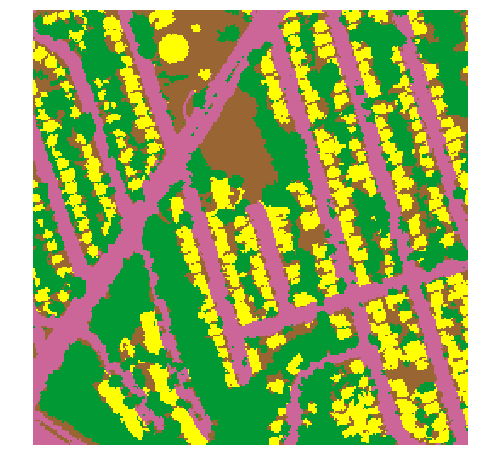

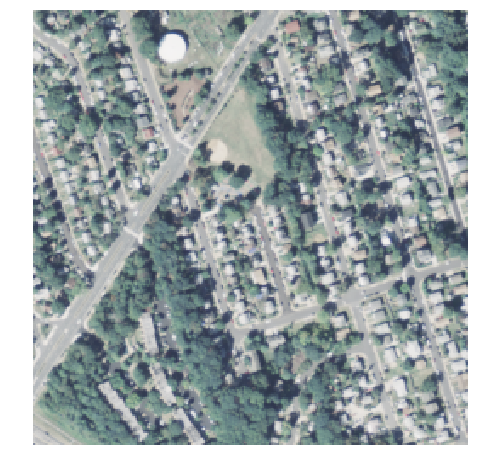

CPU times: user 2.09 s, sys: 445 ms, total: 2.54 s
Wall time: 1.91 s


In [11]:
%%time
final_image = np.zeros((bigsize,bigsize,3),dtype=int)
for i in range(results.shape[0]):
    for j in range(results.shape[1]):
        temp = results[i,j]/np.sum(results[i,j])
        temp *= 5
        temp = np.exp(temp)/np.sum(np.exp(temp))
        #print(temp)
        color = np.dot(temp,palette).astype(int)
        final_image[i,j] = color
disp(final_image)
disp(palette[lc[x:x+bigsize,y:y+bigsize]])
disp(query)

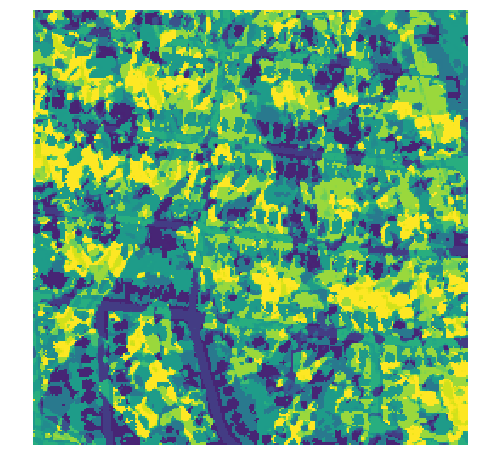

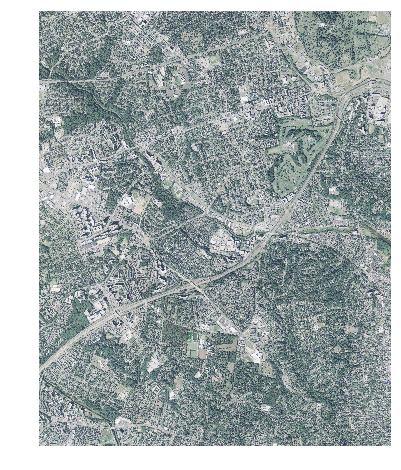

In [10]:
diff = np.sum(final_image-palette[lc2[x:x+bigsize,y:y+bigsize]],axis=2)
disp(diff)
disp(naip)

In [48]:
np.sum(diff<10)/(bigsize**2)

0.5938873291015625

In [7]:
c = rasterio.open("/mnt/blobfuse/esri-naip/"+fn(0).replace('-','/')+".mrf",'r')
naip = c.read()[:3,:,:]
naip = np.rollaxis(naip,0,3)
c.close()
print(naip.shape)

(7662, 6185, 3)


In [17]:
patches = extract_patches_2d(naip,(8,8))

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


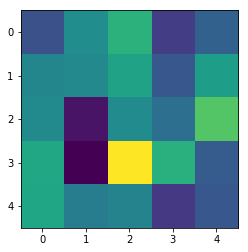

In [12]:
plt.ion()
for i in range(5):
    m = np.random.randn(5,5)
    plt.imshow(m)
    plt.draw()
    time.sleep(1)